# Training Kalman Filter for Results - 10 Feb

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.fastai import *
from meteo_imp.kalman.filter import *
from meteo_imp.utils import *
from meteo_imp.data import *
from meteo_imp.gaussian import *

from fastai.tabular.learner import *
from fastai.learner import *
from fastai.callback.all import *
from fastcore.foundation import L
from fastcore.foundation import patch
from pathlib import Path, PosixPath

from meteo_imp.kalman.fastai import show_results
import pandas as pd
import numpy as np
import torch
import random
from pyprojroot import here

from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from IPython.display import Image

from tqdm.auto import tqdm

In [ ]:
reset_seed()

In [ ]:
hai = pd.read_parquet(hai_big_path)
hai_era = pd.read_parquet(hai_era_big_path)

In [ ]:
base = here("analysis/results/trained_10feb")

In [ ]:
base.mkdir(exist_ok=True)

In [ ]:
@patch
def add_end(self: PosixPath, end): return self.parent / (self.name + end)

In [ ]:
def train_or_load(model, dls, lr, n, path, keep=True):
    save_models = SaveModelsBatch(times_epoch=5)
    csv_logger = CSVLogger(path.add_end("log.csv"))
    learn = Learner(dls, model, KalmanLoss(only_gap=True), cbs = [Float64Callback, save_models, csv_logger], metrics=rmse_gap) 
    items = random.choices(dls.valid.items, k=4) 
    if path.add_end(".pickle").exists() and keep:
        learn.model = torch.load(path.add_end(".pickle"))
        display(csv_logger.read_log())
        plot = Image(filename=path.add_end("_loss_plot.png"))
        display(plot)
    else:
        learn.fit(lr, n)
        
        torch.save(learn.model, path.add_end(".pickle"))
        learn.recorder.plot_loss()
        plt.savefig(path.add_end("_loss_plot.png"))
    return learn, items                           

In [ ]:
def metric_valid(learn, dls=None):
    nrmse = []
    losses = []
    dls = ifnone(dls, learn.dls.valid)
    for input, target in tqdm(dls):
        pred = learn.model(input)
        nrmse.append(learn.metrics[0](pred, target))
        losses.append(learn.loss_func(pred, target))
    metric = pd.DataFrame({'loss': losses, 'rmse': nrmse})
    return metric.agg(['mean', 'std'])

## Generic model | gap len 3-336 | gap 1 random 

In [ ]:
dls_A1v = imp_dataloader(
    df = hai,
    control = hai_era,
    var_sel = gen_var_sel(list(hai.columns), n_var=1),
    block_len=100+336,
    gap_len=gen_gap_len(3, 336),
    bs=20,
    control_lags=[1],
    shifts=gen_shifts(50),
    n_rep=5).cpu()

In [ ]:
model_A1v = KalmanFilterSR.init_local_slope_pca(len(hai.columns),len(hai.columns), df_pca = hai, pred_only_gap=True)

epoch,train_loss,valid_loss,rmse_gap,time
0,193.353548,146.601647,0.573572,56:22
1,119.679036,104.690430,0.456970,28:54
2,95.036298,96.871684,0.428096,28:10


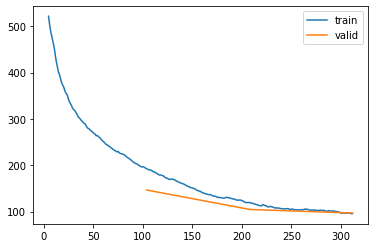

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 3, 1e-3, base / "1_gap_varying_3-336_v1")

epoch,train_loss,valid_loss,rmse_gap,time
0,84.311968,90.426712,0.423037,28:23
1,82.107866,91.031837,0.421232,28:10
2,77.419564,87.781942,0.414014,28:10


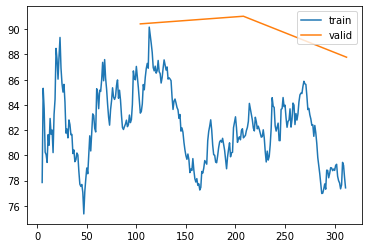

In [ ]:
learn_A1v_3_336, items_A1v_3_336 = train_or_load(learn_A1v_3_336.model, dls_A1v_3_336, 3, 3e-4, base / "1_gap_varying_3-336_v2")

In [ ]:
metric_valid(learn_A1v)

  0%|          | 0/104 [00:00<?, ?it/s]

tensor(0.6385)

## 1 var gap - varying 336

In [ ]:
dls_A1v = imp_dataloader(hai, hai_era, var_sel = gen_var_sel(list(hai.columns), n_var=1), block_len=100+336, gap_len=336, bs=20, control_lags=[1], shifts=gen_shifts(100), n_rep=5).cpu()

In [ ]:
model_A1v = KalmanFilterSR.init_local_slope_pca(len(hai.columns),len(hai.columns), df_pca = hai, pred_only_gap=True)

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,380.364158,326.784700,0.654934,37:33
1,1,262.864349,251.467301,0.544807,36:21
2,2,226.285225,224.678909,0.510671,37:07


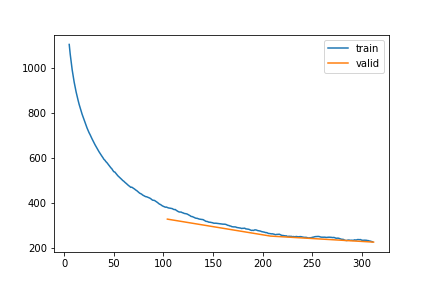

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 3, 1e-3, base / "1_gap_varying_336_v1")

epoch,train_loss,valid_loss,rmse_gap,time
0,210.306824,226.292560,0.515331,34:10
1,194.038559,215.131606,0.501236,34:28
2,179.726920,219.458045,0.494683,35:07


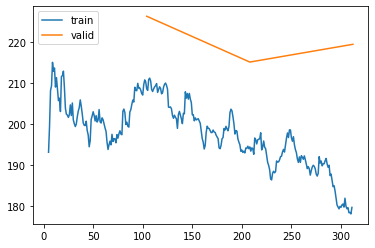

In [ ]:
learn_A1v, items_A1v = train_or_load(learn_A1v.model, dls_A1v, 3, 5e-4, base / "1_gap_varying_336_v2")

In [ ]:
metric_valid(learn_A1v)

  0%|          | 0/104 [00:00<?, ?it/s]

tensor(0.6385)

## specialized - 336

In [ ]:
from fastcore.basics import *

  0%|          | 0/7 [00:00<?, ?it/s]

TA


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.1922)


epoch,train_loss,valid_loss,rmse_gap,time
0,-81.093778,-104.159000,0.166248,06:16
1,-84.834773,-106.050784,0.165263,06:00
2,-87.109282,-102.665867,0.166997,06:06


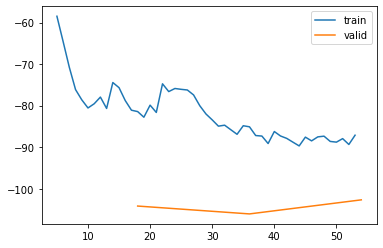

SW_IN


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.4037)


epoch,train_loss,valid_loss,rmse_gap,time
0,160.621421,174.782384,0.388784,06:06
1,157.405052,166.831662,0.377933,05:59
2,154.271775,159.928757,0.369818,05:54


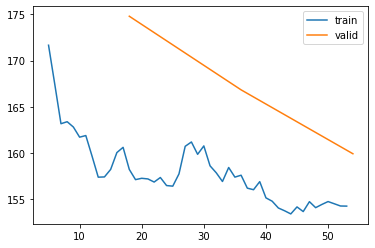

VPD


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.3689)


epoch,train_loss,valid_loss,rmse_gap,time
0,140.376146,117.570909,0.328519,06:00
1,138.040741,117.735460,0.328837,06:00
2,134.452653,114.205389,0.325095,06:05


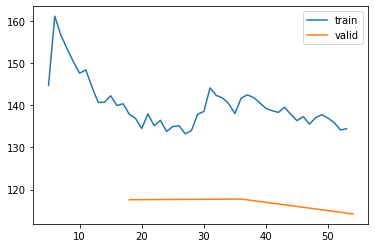

PA


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.1740)


epoch,train_loss,valid_loss,rmse_gap,time
0,-128.848067,-137.885327,0.148628,06:01
1,-132.304557,-137.966789,0.148846,06:06
2,-136.150283,-143.414496,0.146501,06:09


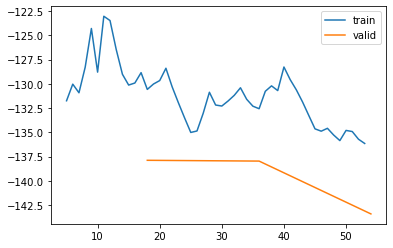

P


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.7784)


epoch,train_loss,valid_loss,rmse_gap,time
0,519.043227,472.439331,0.783632,06:06
1,517.332604,471.824805,0.781104,06:01
2,518.413386,471.067908,0.777673,05:53


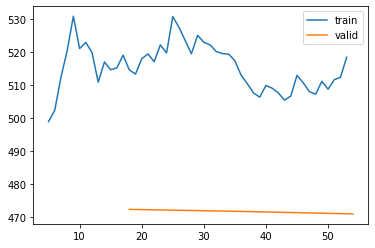

WS


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.8421)


epoch,train_loss,valid_loss,rmse_gap,time
0,333.000027,458.373029,0.827292,05:54
1,331.586878,456.518645,0.820882,05:55
2,330.133510,455.193754,0.816275,05:50


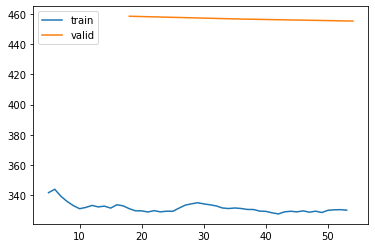

LW_IN


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.5680)


epoch,train_loss,valid_loss,rmse_gap,time
0,269.813482,284.994682,0.554712,05:50
1,266.140870,280.236376,0.546786,05:50
2,263.271720,275.480894,0.538800,06:05


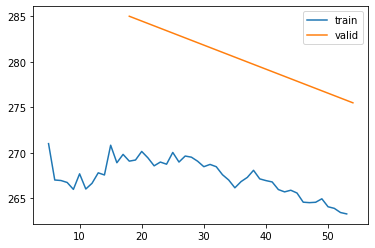

In [ ]:
spec_models = {}
spec_dls = {}
spec_learn = {}
spec_items = {}
for var in tqdm(list(hai.columns)):
    print(var) # 1 week
    spec_dls[var] = imp_dataloader(hai, hai_era, var_sel = var, block_len=500, gap_len=336, bs=20, control_lags=[1], n_rep=1, shifts=gen_shifts(50)).cpu()
    spec_models[var] = learn_A1v.model.copy()
    print(metric_valid(learn_A1v, dls=spec_dls[var].valid))
    spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], 3, 2e-5, base / f"{var}_specialized_gap_336_v2.pickle")
    plt.show()
    

  0%|          | 0/2 [00:00<?, ?it/s]

SW_IN


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.4037)


epoch,train_loss,valid_loss,rmse_gap,time
0,147.081102,153.592512,0.361692,05:47
1,144.984204,147.233722,0.353274,05:55
2,141.840183,142.120207,0.347047,05:50


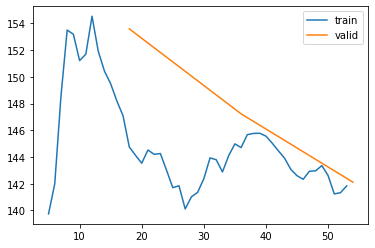

LW_IN


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.5680)


epoch,train_loss,valid_loss,rmse_gap,time
0,257.296672,271.268047,0.532025,05:54
1,254.709431,267.527692,0.526062,05:57
2,251.984433,264.003732,0.520479,05:49


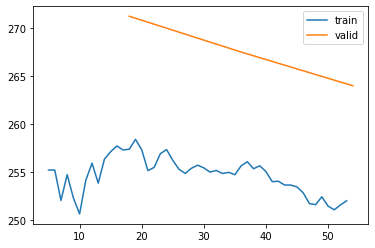

In [ ]:
spec_learn2 = {}
for var in tqdm(['SW_IN', 'LW_IN']):
    print(var) # 1 week
    print(metric_valid(spec_learn[var].model, dls=spec_dls[var].valid))
    spec_learn2[var], _ = train_or_load(spec_learn[var].model, spec_dls[var], 3, 5e-5, base / f"{var}_specialized_gap_336_v3.pickle")
    plt.show()
    

## 1 var gap - varying 336 - No Control

In [ ]:
dls_A1v_nc = imp_dataloader(hai, hai_era, var_sel = gen_var_sel(list(hai.columns), n_var=1), block_len=100+336, gap_len=336, bs=5, control_lags=[1], shifts=gen_shifts(100), n_rep=5).cpu()

In [ ]:
model_A1v_nc = KalmanFilterSR.init_local_slope_pca(len(hai.columns),len(hai.columns), df_pca = hai, pred_only_gap=True, use_control=False)

epoch,train_loss,valid_loss,rmse_gap,time
0,378.058011,371.085483,0.681375,43:37
1,367.492877,360.823709,0.665902,44:50
2,339.345100,364.711690,0.674149,45:11


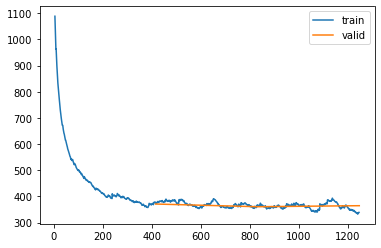

In [ ]:
learn_A1v_nc, items_A1v_nc = train_or_load(model_A1v_nc, dls_A1v_nc, 3, 1e-3, base / "1_gap_varying_336_no_control_v1", keep=False)

## All variables - 30 all

In [ ]:
dls_Aa = imp_dataloader(hai, hai_era, var_sel = list(hai.columns), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=10).cpu()

In [ ]:
model_Aa = learn_A1v_3_336.model.copy()

epoch,train_loss,valid_loss,rmse_gap,time
0,68.920740,73.037300,0.457492,24:24
1,50.691507,59.431252,0.440490,24:14


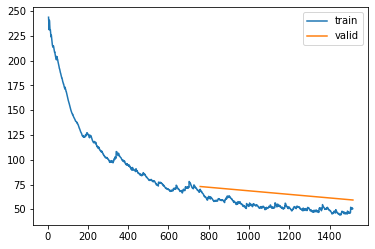

In [ ]:
learn_Aa, items_Aa = train_or_load(model_Aa, dls_Aa, 2, 3e-4, base / "All_gap_all_30_v1")

## 1 var gap - varying 30

In [ ]:
dls_A1v30 = imp_dataloader(hai, hai_era, var_sel = gen_var_sel(list(hai.columns), n_var=1), block_len=100+30, gap_len=30, bs=20, control_lags=[1], shifts=gen_shifts(50), n_rep=5).cpu()

In [ ]:
model_A1v30 = learn_A1v_3_336.model.copy()

loss generic model

In [ ]:
metric_valid(learn_A1v, dls=dls_A1v30.valid)

  0%|          | 0/88 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,rmse_gap,time
0,10.150969,10.634211,0.350033,12:53
1,6.587447,8.556643,0.334815,12:49


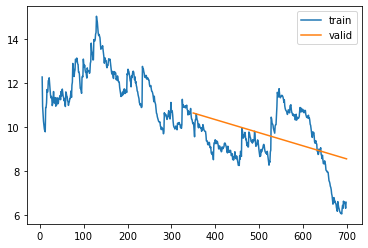

In [ ]:
learn_A1v30, items_A1v30 = train_or_load(model_A1v30, dls_A1v30, 2, 1e-3, base / "1_gap_varying_30_v1")

### Fine gap length

  0%|          | 0/7 [00:00<?, ?it/s]

TA


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.1922)


epoch,train_loss,valid_loss,rmse_gap,time
0,-81.093778,-104.159000,0.166248,06:16
1,-84.834773,-106.050784,0.165263,06:00
2,-87.109282,-102.665867,0.166997,06:06


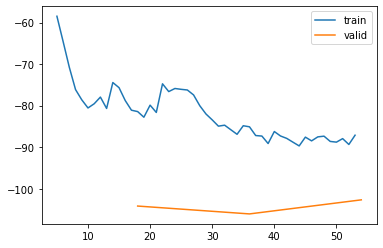

SW_IN


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.4037)


epoch,train_loss,valid_loss,rmse_gap,time
0,160.621421,174.782384,0.388784,06:06
1,157.405052,166.831662,0.377933,05:59
2,154.271775,159.928757,0.369818,05:54


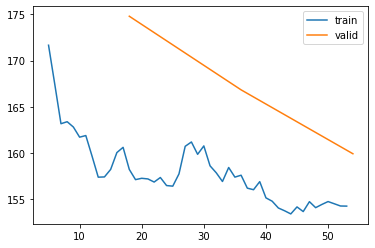

VPD


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.3689)


epoch,train_loss,valid_loss,rmse_gap,time
0,140.376146,117.570909,0.328519,06:00
1,138.040741,117.735460,0.328837,06:00
2,134.452653,114.205389,0.325095,06:05


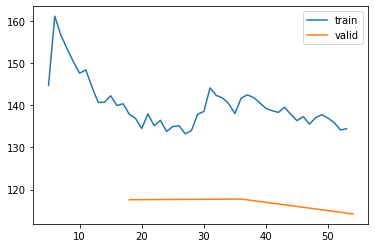

PA


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.1740)


epoch,train_loss,valid_loss,rmse_gap,time
0,-128.848067,-137.885327,0.148628,06:01
1,-132.304557,-137.966789,0.148846,06:06
2,-136.150283,-143.414496,0.146501,06:09


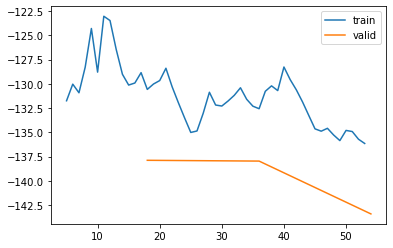

P


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.7784)


epoch,train_loss,valid_loss,rmse_gap,time
0,519.043227,472.439331,0.783632,06:06
1,517.332604,471.824805,0.781104,06:01
2,518.413386,471.067908,0.777673,05:53


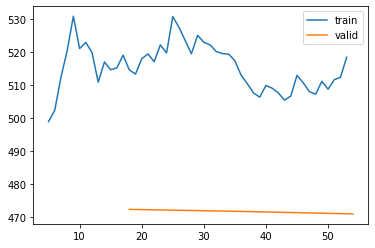

WS


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.8421)


epoch,train_loss,valid_loss,rmse_gap,time
0,333.000027,458.373029,0.827292,05:54
1,331.586878,456.518645,0.820882,05:55
2,330.133510,455.193754,0.816275,05:50


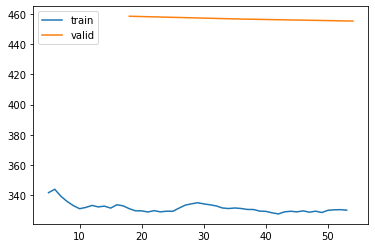

LW_IN


  0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.5680)


epoch,train_loss,valid_loss,rmse_gap,time
0,269.813482,284.994682,0.554712,05:50
1,266.140870,280.236376,0.546786,05:50
2,263.271720,275.480894,0.538800,06:05


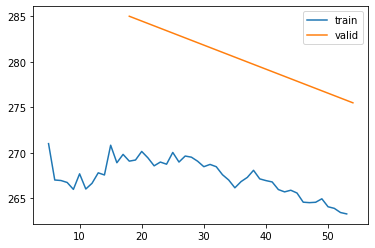

In [ ]:
gap_models = {}
gap_dls = {}
gap_learn = {}
gap_items = {}
for gap_len in tqdm(list():
    print(f"Gap len: {gep_len}")
    gap_dls[gap_len] = imp_dataloader(hai, hai_era, var_sel = gen_var_sel(list(hai.columns), n_var=1), block_len=gap_len+100, gap_len=gap_len, bs=20, control_lags=[1], n_rep=4, shifts=gen_shifts(50)).cpu()
    gap_models[gap_len] = learn_A1v.model.copy()
    print(metric_valid(learn_A1v, dls=spec_dls[var].valid))
    spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], 3, 2e-5, base / f"{var}_specialized_gap_336_v2.pickle")
    plt.show()
    

 # === OLD ===


## All variables - 336 varying 

Model Av (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_Av = imp_dataloader(haiB, hai_eraB, var_sel = gen_var_sel(list(haiB.columns)), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=10).cpu()

In [ ]:
model_Av = KalmanFilterSR.init_local_slope_pca(len(haiB.columns),len(haiB.columns), df_pca = haiB, pred_only_gap=True, use_conditional=False)

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,26.214190,30.346192,0.386696,36:35
1,1,17.806891,21.144149,0.366064,38:40


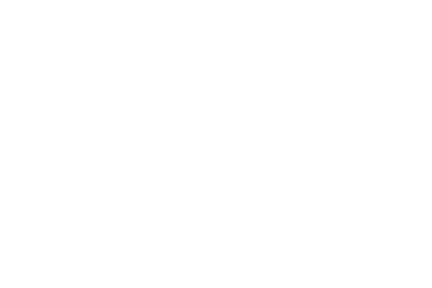

In [ ]:
learn_Av, items_Av = train_or_load(model_Av, dls_Av, 2, 1e-3, base / "All_gap_varying_30_v1")

In [ ]:
metric_valid(learn_Av)

In [ ]:
model_Av.copy??

In [ ]:
learn_Av, items_Av = train_or_load(model_Av, dls_Av, 1, 5e-4, base / "All_gap_varying_30_v2")

In [ ]:
show_results(learn_Av, items=items_Av, control_map=control_map)

### 1 var gap - varying 672

In [ ]:
dls_A1v = imp_dataloader(haiB[:30_000], hai_eraB, var_sel = gen_var_sel(list(haiB.columns), n_var=1), block_len=800, gap_len=672, bs=5, control_lags=[1], shifts=gen_shifts(300), n_rep=1).cpu()

In [ ]:
model_A1v = KalmanFilterSR.init_local_slope_pca(len(haiB.columns),len(haiB.columns), df_pca = haiB, pred_only_gap=True, use_conditional=False)

epoch,train_loss,valid_loss,rmse_gap,time
0,1566.155526,1446.904870,0.980710,01:21
1,1421.453610,1254.100269,0.943964,01:20


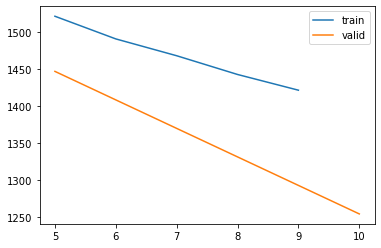

In [ ]:
learn_A1v, items_A1v = train_or_load(model_A1v, dls_A1v, 2, 1e-3, base / "1_gap_varying_672_v1")

## All variables - 30 all

In [ ]:
dls_Aa = imp_dataloader(haiB, hai_eraB, var_sel = list(haiB.columns), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=1).cpu()

In [ ]:
model_Aa = model_Av.copy()

epoch,train_loss,valid_loss,rmse_gap,time
0,33.282077,39.916592,0.410030,02:31
1,31.570166,40.208255,0.410228,02:20


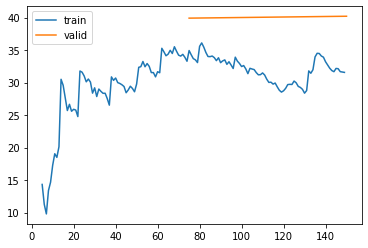

In [ ]:
learn_Aa, items_Aa = train_or_load(model_Aa, dls_Aa, 2, 3e-4, base / "All_gap_all_30_v1", keep=False)

In [ ]:
show_results(learn_Aa, items=items_Aa, control_map=control_map)

[MeteoImpItem(i=1647, shift=-60, var_sel=['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN'], gap_len=30), MeteoImpItem(i=1765, shift=-60, var_sel=['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN'], gap_len=30), MeteoImpItem(i=1785, shift=-60, var_sel=['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN'], gap_len=30), MeteoImpItem(i=1717, shift=-60, var_sel=['TA', 'SW_IN', 'VPD', 'PA', 'P', 'WS', 'LW_IN'], gap_len=30)]


alt.HConcatChart(...)

## All variables - 12 varying 

Model Av (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_Av12 = imp_dataloader(haiB, hai_eraB, var_sel = gen_var_sel(list(haiB.columns)), block_len=80, gap_len=12, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_Av12 = model_Av.copy()

epoch,train_loss,valid_loss,rmse_gap,time
0,-5.242486,-5.854822,0.276692,13:14


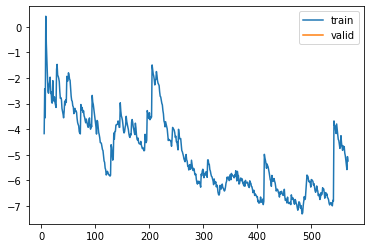

In [ ]:
learn_Av12, items_Av12 = train_or_load(model_Av12, dls_Av12, 1, 1e-4, base / "All_gap_varying_12_v1")

In [ ]:
show_results(learn_Av12, items=items_Av12, control_map=control_map)

[MeteoImpItem(i=2681, shift=-8, var_sel=['WS', 'VPD', 'SW_IN', 'P', 'TA', 'LW_IN'], gap_len=12), MeteoImpItem(i=2429, shift=-8, var_sel=['WS', 'PA', 'TA', 'LW_IN', 'VPD', 'P'], gap_len=12), MeteoImpItem(i=2846, shift=-8, var_sel=['WS', 'P', 'VPD'], gap_len=12), MeteoImpItem(i=2377, shift=-40, var_sel=['LW_IN', 'PA'], gap_len=12)]


alt.HConcatChart(...)

## TA - 30

In [ ]:
dls_TA = imp_dataloader(haiB, hai_eraB, var_sel = 'TA', block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_TA = model_Av.copy()

In [ ]:
learn_TA, save_models_TA, items_TA = train_or_load(model_TA, dls_TA, 2, 2e-4, base / "TA_30_v1.pickle")

FileNotFoundError: [Errno 2] No such file or directory: '/home/simone/Documents/uni/Thesis/GPFA_imputation/analysis/results/trained_8feb/TA_30_v1.picklelog.csv'

In [ ]:
learn_TA, items_TA, loggerTA = train_or_load(model_TA, dls_TA, 1, 2e-4, base / "TA_30_v2.pickle")

In [ ]:
loggerTA.read_log()

,epoch,train_loss,valid_loss,rmse_gap,time
0,0,-22.20629,-22.448926,0.097302,11:15


In [ ]:
show_results(learn_TA, items=items_TA, control_map=control_map, hide_no_gap=True)

### TA - 96

Model TA

In [ ]:
dls_TA96 = imp_dataloader(haiB, hai_eraB, var_sel = 'TA', block_len=350, gap_len=96, bs=20, control_lags=[1], n_rep=1).cpu()

In [ ]:
model_TA96 = learn_Av.model.copy()

In [ ]:
learn_TA96, save_models_TA96, items_TA96 = train_or_load(model_TA96, dls_TA96, 2, 2e-4, base / "TA_96_v1.pickle")

In [ ]:
show_results(learn_TA96, items=items_TA96, control_map=control_map, hide_no_gap=True)

### Train specialized models

epoch,train_loss,valid_loss,rmse_gap,time
0,-39.692397,-42.531067,0.131699,00:42
1,-45.283476,-33.323406,0.144391,00:37


epoch,train_loss,valid_loss,rmse_gap,time
0,49.694907,6.908584,0.222646,00:38
1,45.584341,10.284428,0.239156,00:39


epoch,train_loss,valid_loss,rmse_gap,time
0,27.420796,-6.238979,0.190993,00:40
1,24.375462,-4.962333,0.200030,00:38


epoch,train_loss,valid_loss,rmse_gap,time
0,-111.954325,-106.969053,0.075821,00:42
1,-118.061853,-119.208259,0.065790,00:40


epoch,train_loss,valid_loss,rmse_gap,time
0,122.597622,113.888477,0.592852,00:41
1,124.965769,113.211150,0.584031,00:40


epoch,train_loss,valid_loss,rmse_gap,time
0,85.440672,82.872583,0.552278,00:39
1,85.644038,82.978043,0.553163,00:38


epoch,train_loss,valid_loss,rmse_gap,time
0,31.828594,27.359172,0.290250,00:43
1,29.653514,26.873250,0.288271,00:38


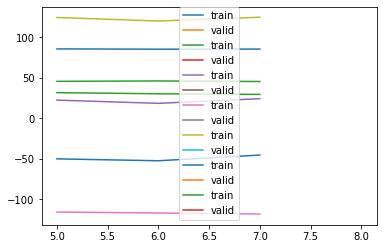

In [ ]:
spec_models = {}
spec_dls = {}
spec_learn = {}
spec_items = {}
for var in list(haiB.columns):
    print(var)
    spec_dls[var] = imp_dataloader(haiB[:40000], hai_eraB, var_sel = var, block_len=350, gap_len=96, bs=20, control_lags=[1], n_rep=1).cpu()
    spec_models[var] = learn_Av.model.copy()
    spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], 2, 2e-4, base / f"{var}_specialized_v1.pickle")
   

  0%|          | 0/7 [00:00<?, ?it/s]

TA


epoch,train_loss,valid_loss,rmse_gap,time
0,90.643715,-16.383068,0.177646,00:36


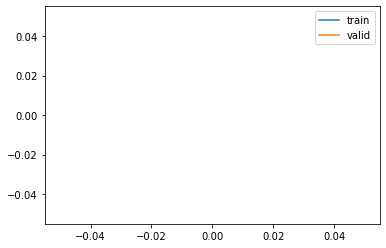

SW_IN


epoch,train_loss,valid_loss,rmse_gap,time
0,62.269008,103.003446,0.385411,00:40


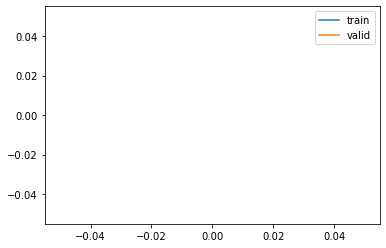

VPD


epoch,train_loss,valid_loss,rmse_gap,time
0,95.957126,285.851886,0.495180,00:41


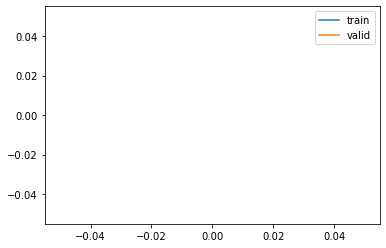

PA


epoch,train_loss,valid_loss,rmse_gap,time
0,-51.859173,-69.926766,0.125275,00:43


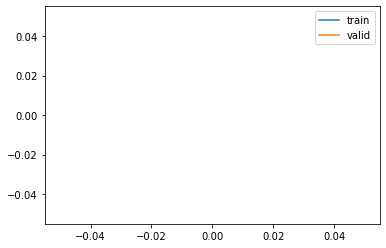

P


epoch,train_loss,valid_loss,rmse_gap,time
0,289.581748,212.260866,0.520403,00:40


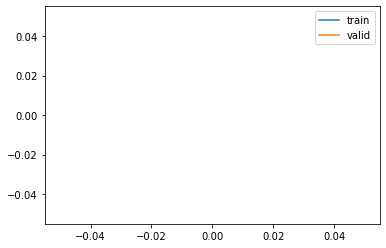

WS


epoch,train_loss,valid_loss,rmse_gap,time
0,208.126112,177.603145,0.593094,00:39


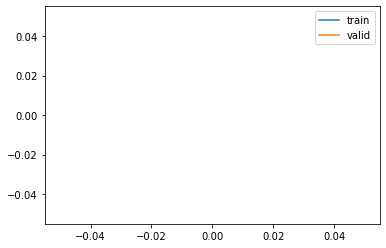

LW_IN


epoch,train_loss,valid_loss,rmse_gap,time
0,63.759073,62.438796,0.308980,00:41


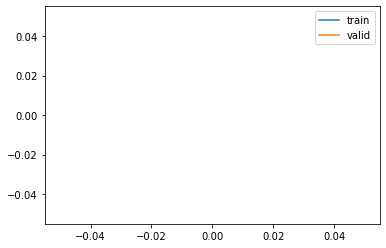

In [ ]:
spec_models = {}
spec_dls = {}
spec_learn = {}
spec_items = {}
for var in tqdm(list(haiB.columns)):
    print(var)
    spec_dls[var] = imp_dataloader(haiB[:30000], hai_eraB, var_sel = var, block_len=500, gap_len=192, bs=20, control_lags=[1], n_rep=1).cpu()
    spec_models[var] = learn_Av.model.copy()
    spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], 1, 1e-4, base / f"{var}_specialized_gap_192_v1.pickle")
    plt.show()
    

  0%|          | 0/7 [00:00<?, ?it/s]

TA


epoch,train_loss,valid_loss,rmse_gap,time
0,244.441678,-39.264206,0.179186,00:42


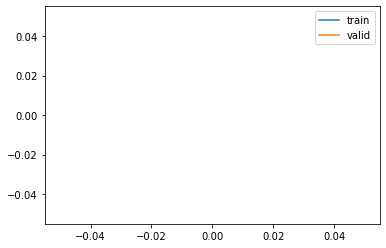

SW_IN


epoch,train_loss,valid_loss,rmse_gap,time
0,92.375716,216.062288,0.416458,00:43


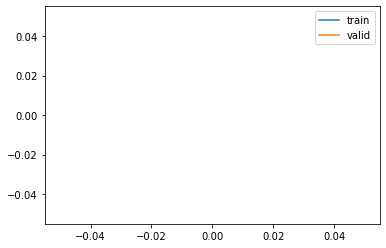

VPD


epoch,train_loss,valid_loss,rmse_gap,time
0,182.519898,378.167553,0.452476,00:45


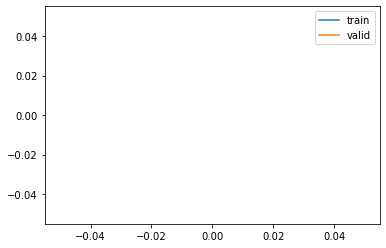

PA


epoch,train_loss,valid_loss,rmse_gap,time
0,22.902731,-134.399585,0.125682,00:45


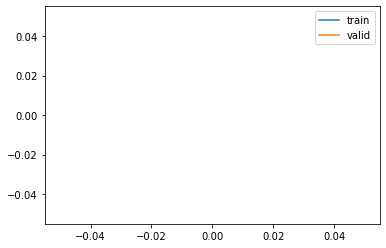

P


epoch,train_loss,valid_loss,rmse_gap,time
0,449.964537,412.074092,0.671240,00:44


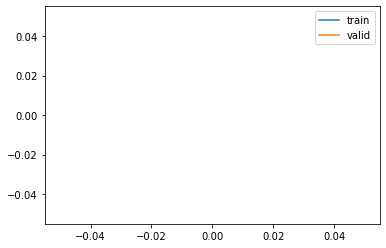

WS


epoch,train_loss,valid_loss,rmse_gap,time
0,373.671535,304.890972,0.592034,00:45


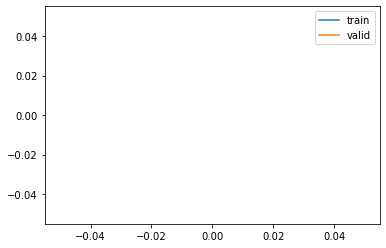

LW_IN


epoch,train_loss,valid_loss,rmse_gap,time
0,108.351227,109.968726,0.309430,00:44


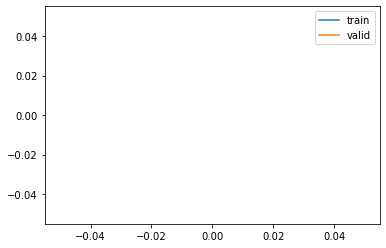

In [ ]:
spec_models = {}
spec_dls = {}
spec_learn = {}
spec_items = {}
for var in tqdm(list(haiB.columns)):
    print(var) # 1 week
    spec_dls[var] = imp_dataloader(haiB[:30000], hai_eraB, var_sel = var, block_len=500, gap_len=336, bs=20, control_lags=[1], n_rep=1).cpu()
    spec_models[var] = learn_Av.model.copy()
    spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], 1, 1e-4, base / f"{var}_specialized_gap_336_v1.pickle")
    plt.show()
    

  0%|          | 0/7 [00:00<?, ?it/s]

TA


epoch,train_loss,valid_loss,rmse_gap,time
0,657.307163,118.648190,0.204232,01:09


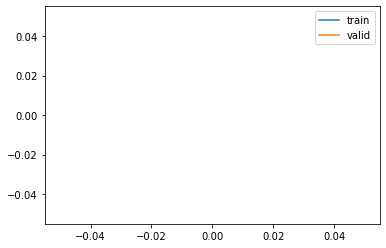

SW_IN


epoch,train_loss,valid_loss,rmse_gap,time
0,262.173894,525.063575,0.456621,01:11


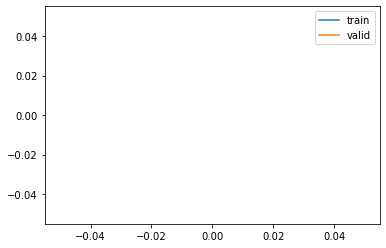

VPD


epoch,train_loss,valid_loss,rmse_gap,time
0,493.652948,311.636245,0.362475,01:12


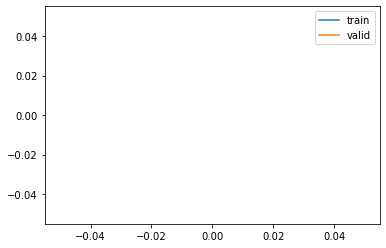

PA


epoch,train_loss,valid_loss,rmse_gap,time
0,82.584014,-149.931723,0.136190,01:14


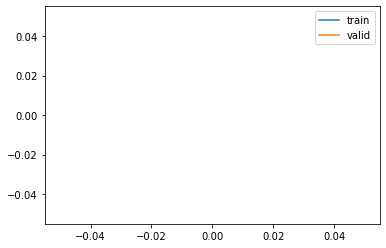

P


epoch,train_loss,valid_loss,rmse_gap,time
0,970.131864,821.798107,0.729170,01:18


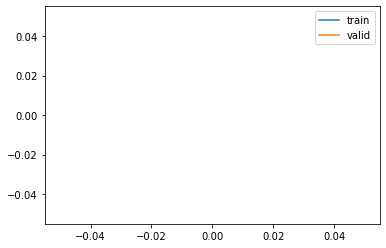

WS


epoch,train_loss,valid_loss,rmse_gap,time
0,806.418451,579.607119,0.573610,01:16


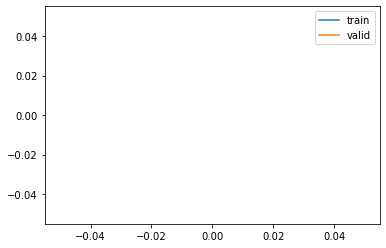

LW_IN


epoch,train_loss,valid_loss,rmse_gap,time
0,228.687149,231.744756,0.317265,01:15


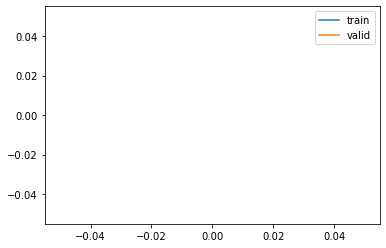

In [ ]:
spec_models = {}
spec_dls = {}
spec_learn = {}
spec_items = {}
for var in tqdm(list(haiB.columns)):
    print(var) # 2 weeks
    spec_dls[var] = imp_dataloader(haiB[:30000], hai_eraB, var_sel = var, block_len=1000, gap_len=672, bs=20, control_lags=[1], n_rep=1).cpu()
    spec_models[var] = learn_Av.model.copy()
    spec_learn[var], spec_items[var] = train_or_load(spec_models[var], spec_dls[var], 1, 1e-4, base / f"{var}_specialized_gap_672_v1.pickle")
    plt.show()
    

In [ ]:
def train_specialized(gap_len=30, block_len=120, bs=20, df=haiB, control=hai_eraB):
    

## SW_IN - 30

In [ ]:
dls_SW_IN = imp_dataloader(haiB, hai_eraB, var_sel = 'SW_IN', block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_SW_IN = model_Av.copy()

epoch,train_loss,valid_loss,rmse_gap,time
0,8.902548,7.420177,0.267329,14:57
1,5.782914,5.721588,0.249692,10:34


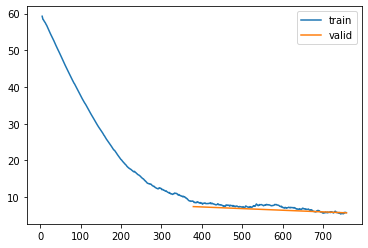

In [ ]:
learn_SW_IN, items_SW_IN = train_or_load(model_SW_IN, dls_SW_IN,  2, 2e-4, base / "SW_IN_30_v1")

In [ ]:
show_results(learn_SW_IN, items=items_SW_IN, control_map=control_map, hide_no_gap=True)

[MeteoImpItem(i=1588, shift=-60, var_sel=['SW_IN'], gap_len=30), MeteoImpItem(i=1863, shift=12, var_sel=['SW_IN'], gap_len=30), MeteoImpItem(i=1704, shift=36, var_sel=['SW_IN'], gap_len=30), MeteoImpItem(i=1545, shift=12, var_sel=['SW_IN'], gap_len=30)]


alt.HConcatChart(...)

### SW_IN - 96

Model SW_IN (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_SW_IN96 = imp_dataloader(haiB, hai_eraB, var_sel = 'SW_IN', block_len=350, gap_len=96, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_SW_IN96 = model_SW_IN.copy()

In [ ]:
learn_SW_IN96, save_models_SW_IN96, items_SW_IN96 = train_or_load(model_SW_IN96, dls_SW_IN96, 2, 2e-4, base / "SW_IN_96_v1.pickle")

In [ ]:
show_results(learn_SW_IN96, items=items_SW_IN96, control_map=control_map, hide_no_gap=True)

## LW_IN - 12

In [ ]:
dls_LW_IN = imp_dataloader(haiB, hai_eraB, var_sel = 'LW_IN', block_len=100, gap_len=12, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_LW_IN = model_Av.copy()

In [ ]:
learn_LW_IN, save_models_LW_IN, items_LW_IN = train_or_load(model_LW_IN, dls_LW_IN, 2, 2e-4, base / "LW_IN_12_v1.pickle")

In [ ]:
show_results(learn_LW_IN, items=items_LW_IN, control_map=control_map, hide_no_gap=True)

### LW_IN - 96

Model LW_IN (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_LW_IN96 = imp_dataloader(haiB, hai_eraB, var_sel = 'LW_IN', block_len=350, gap_len=96, bs=20, control_lags=[1], n_rep=5).cpu()

In [ ]:
model_LW_IN96 = model_LW_IN.copy()

In [ ]:
learn_LW_IN96, save_models_LW_IN96, items_LW_IN96 = train_or_load(model_LW_IN96, dls_LW_IN96, 2, 2e-4, base / "LW_IN_96_v1.pickle")

In [ ]:
show_results(learn_LW_IN96, items=items_LW_IN96, control_map=control_map, hide_no_gap=True)

## No Control

### All variables - 30 varying  - No Control

Model Av_nc (*A*ll *v*arying) all variables with a *v*aring numbers of variables  

In [ ]:
dls_Av_nc = imp_dataloader(haiB, 
                           control = hai_eraB.sample(frac=1).reset_index(drop=True).set_index(hai_eraB.index), #reshuffle so cannot use control
                           var_sel = gen_var_sel(list(haiB.columns)), block_len=120, gap_len=30, bs=20, control_lags=[1], n_rep=10).cpu()

In [ ]:
model_Av_nc =  KalmanFilterSR.init_local_slope_pca(len(haiB.columns),len(haiB.columns), df_pca = haiB, pred_only_gap=True, use_conditional=False, use_control=False)

In [ ]:
learn_Av_nc, items_Av_nc = train_or_load(model_Av_nc, dls_Av_nc, 2, 1e-3, base / "All_gap_varying_30_no_control_v1")

epoch,train_loss,valid_loss,rmse_gap,time
0,48.175866,46.578383,0.431465,38:45


KeyboardInterrupt: 

In [ ]:
show_results(learn_Av_nc, items=items_Av_nc, control_map=control_map)